# Pathway analysis with AUCell

Single-cell RNA sequencing (scRNA-seq) is a powerful tool for exploring variations in cell types between conditions, tissue types, species, and individuals. When conducting scRNA-seq analysis, the differential gene expression (DEG) analysis of the single-cell data is almost always followed by gene set enrichment analysis. The aim of this analysis is to identify gene programs and biological processes, gene ontologies, or regulatory pathways that are overrepresented in a case group compared to a control group.

There are many methods to determine the enrichment pathway between two groups, and the choice of method can significantly impact the conclusion.
 
This tutorial focuses on using AUCell to complete the gene set enrichment in scRNA-seq data.

# Part.1 The Mathematical Principles of AUCell

AUCell uses the “Area Under the Curve” (AUC) to calculate whether a critical subset of the input gene set is enriched within the expressed genes for each cell. The distribution of AUC scores across all the cells allows exploring the relative expression of the signature. Since the scoring method is ranking-based, AUCell is independent of the gene expression units and the normalization procedure.

 In brief, the scoring method is based on a recovery analysis where the x-axis  is the ranking of all genes based on expression level (genes with the same expression value, e.g., '0', are randomly sorted); and the y-axis is the number of genes recovered from the input set. AUCell then uses the AUC to **calculate whether a critical subset of the input gene set is enriched at the top of the ranking for each cell**. In this way, the AUC represents the proportion of expressed genes in the signature and their relative expression values compared to the other genes within the cell. The output of this step is a matrix with the AUC score for each gene set in each cell.


# Part.2 Data preprocess

In this part, we load a test data and perform preliminary processing of the data, such as normalization and logarithmization, in order to make the data more interpretable



In [1]:
!pip install -U Pyomic
!pip install scanpy
!pip install scvelo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.7/349.7 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.9/191.9 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 KB

In [2]:
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

Creating directory /root/.config/bioservices 
Pyomic(Ver):  1.2.0
scanpy(Ver):  1.9.3
scvelo(Ver):  0.2.5


In [3]:
Pyomic.utils.download_pathway_database()
Pyomic.utils.download_geneid_annotation_pair()

......Pathway Geneset download start: GO_Biological_Process_2021
......Downloading dataset save to genesets/GO_Biological_Process_2021.txt
......Creating directory genesets
......[GO_Biological_Process_2021 Size of file]: 0.15 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！3.856386423110962.2f s
......Pathway Geneset download start: GO_Cellular_Component_2021
......Downloading dataset save to genesets/GO_Cellular_Component_2021.txt
......[GO_Cellular_Component_2021 Size of file]: 0.03 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！3.1731350421905518.2f s
......Pathway Geneset download start: GO_Molecular_Function_2021
......Downloading dataset save to genesets/GO_Molecular_Function_2021.txt
......[GO_Molecular_Function_2021 Size of file]: 0.03 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！6.263937950134277.2f s
......Pathway Geneset download s

The dataset used here is the mouse pancreas dataset that comes with scvelo

In [4]:
adata = scv.datasets.pancreas()
adata

try downloading from url
https://github.com/theislab/scvelo_notebooks/raw/master/data/Pancreas/endocrinogenesis_day15.h5ad
... this may take a while but only happens once
creating directory data/Pancreas/ for saving data


  0%|          | 0.00/50.0M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [5]:
adata.X.max()

2286.0

In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [7]:
adata.X.max()

7.785111

# Part.3 Pathway anaylsis

In this part, we will demonstrate how to utilize the existing gene set to conduct enrichment analysis and how to create a gene set based on our own ideas for enrichment analysis in the test dataset.

First, we need to download data sets, such as the Gene Ontology(GO) or the Kyoto Encyclopedia of Genes and Genomes(KEGG). It should be noted that here we need to select the correct species, such as 'Human'or 'Mouse'.



In [8]:
import pandas as pd
pathway_dict=Pyomic.utils.geneset_prepare('genesets/GO_Biological_Process_2021.txt',organism='Mouse')

When working with existing datasets, it is possible to use the `Pyomic.single.geneset_aucell` to calculate the activity of a gene set that corresponds to a particular signaling pathway within the dataset. 

Additionally, we can use the `sc.pl.embedding` function to visualize the distribution of gene set activity. By doing so, we can gain insights into the behavior of the gene set within the dataset and how it relates to the signaling pathway of interest.

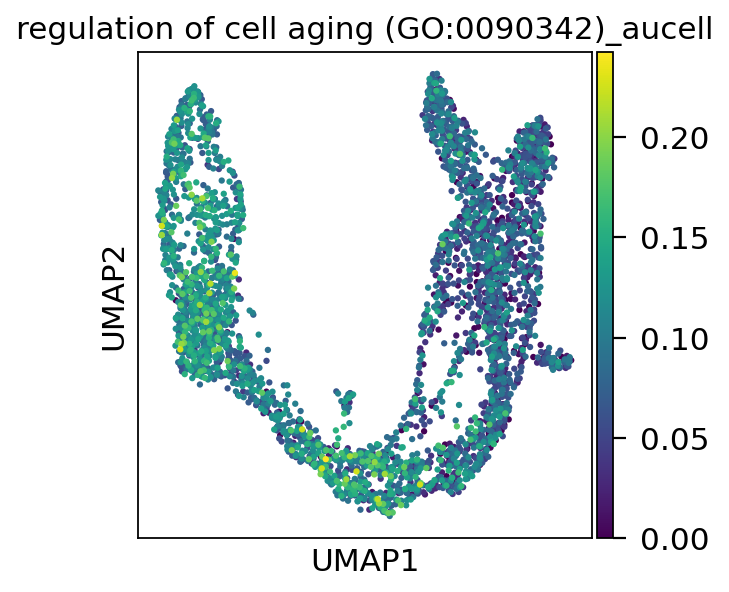

In [9]:
##Assest one geneset
geneset_name='regulation of cell aging (GO:0090342)'
Pyomic.single.geneset_aucell(adata,
                            geneset_name=geneset_name,
                            geneset=pathway_dict[geneset_name])
sc.pl.embedding(adata,
                basis='umap',
          color=["{}_aucell".format(geneset_name)])

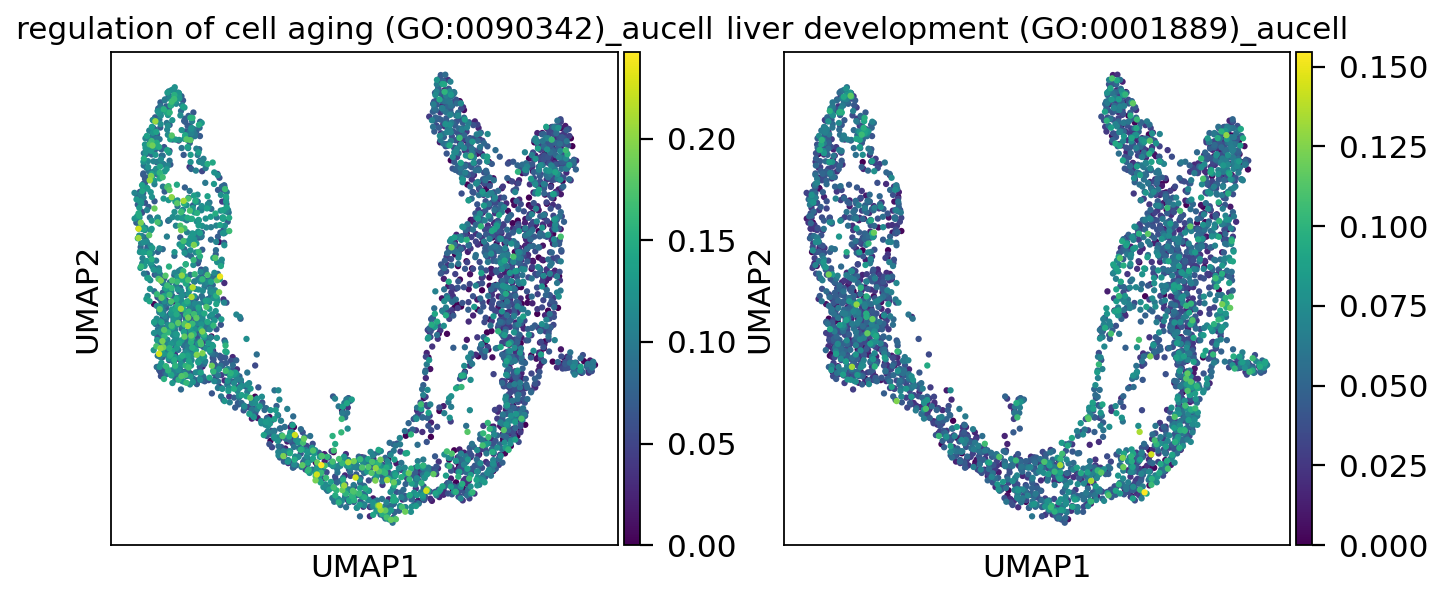

In [10]:
##Assest more than one geneset
geneset_names=['regulation of cell aging (GO:0090342)','liver development (GO:0001889)']
Pyomic.single.pathway_aucell(adata,
                            pathway_names=geneset_names,
                            pathways_dict=pathway_dict)
sc.pl.embedding(adata,
                basis='umap',
          color=["regulation of cell aging (GO:0090342)_aucell","liver development (GO:0001889)_aucell"])

In certain situations, the pathway we wish to investigate may not be available in the database. In such cases, we can manually define the gene set and its corresponding genes, calculate the AUCell activity of the gene set, and then visualize the results. By doing so, we can gain insights into the behavior of the gene set and its associated pathway, even in the absence of a pre-existing database entry.


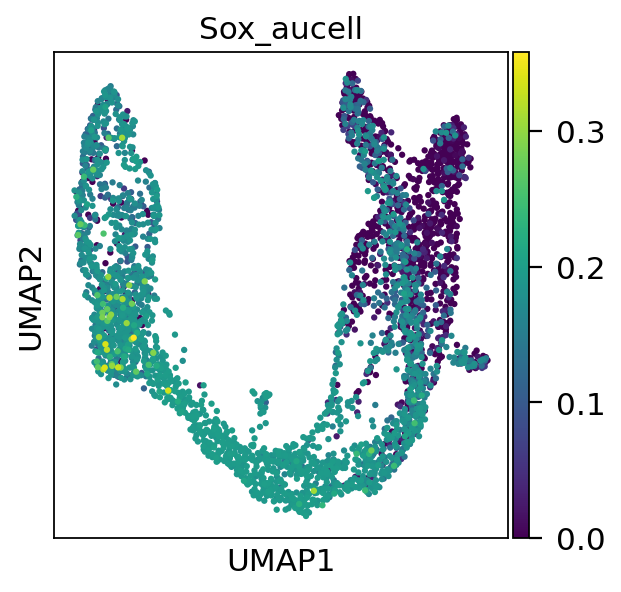

In [11]:
##Assest test geneset
Pyomic.single.geneset_aucell(adata,
                            geneset_name='Sox',
                            geneset=['Sox17', 'Sox4', 'Sox7', 'Sox18', 'Sox5'])
sc.pl.embedding(adata,
                basis='umap',
          color=["Sox_aucell"])

Occasionally, we may wish to examine clusters-specific signaling pathways from a comprehensive perspective. In such cases, we can compute the AUCell scores of all signaling pathways in the database and store the results as an anndata file. Once saved, we can utilize differential expression gene calculation functions and visualization functions from Scanpy to conduct downstream analyses. By taking this approach, we can investigate signaling pathways that are specific to certain clusters and gain insights into the underlying biological mechanisms.


In [12]:
##Assest all pathways
adata_aucs=Pyomic.single.pathway_aucell_enrichment(adata,
                                                  pathways_dict=pathway_dict,
                                                  num_workers=8)
adata_aucs

AnnData object with n_obs × n_vars = 3696 × 6036

We can use the anndata class to store the resulting gene set pathway and visualize it using the functions provided by the anndata class.

In [13]:
adata_aucs.obs=adata[adata_aucs.obs.index].obs
adata_aucs.obsm=adata[adata_aucs.obs.index].obsm
adata_aucs.obsp=adata[adata_aucs.obs.index].obsp

In [14]:
adata_aucs.write_h5ad('/content/pancreas_auce.h5ad',compression='gzip')

In [15]:
adata_aucs=sc.read('/content/pancreas_auce.h5ad')

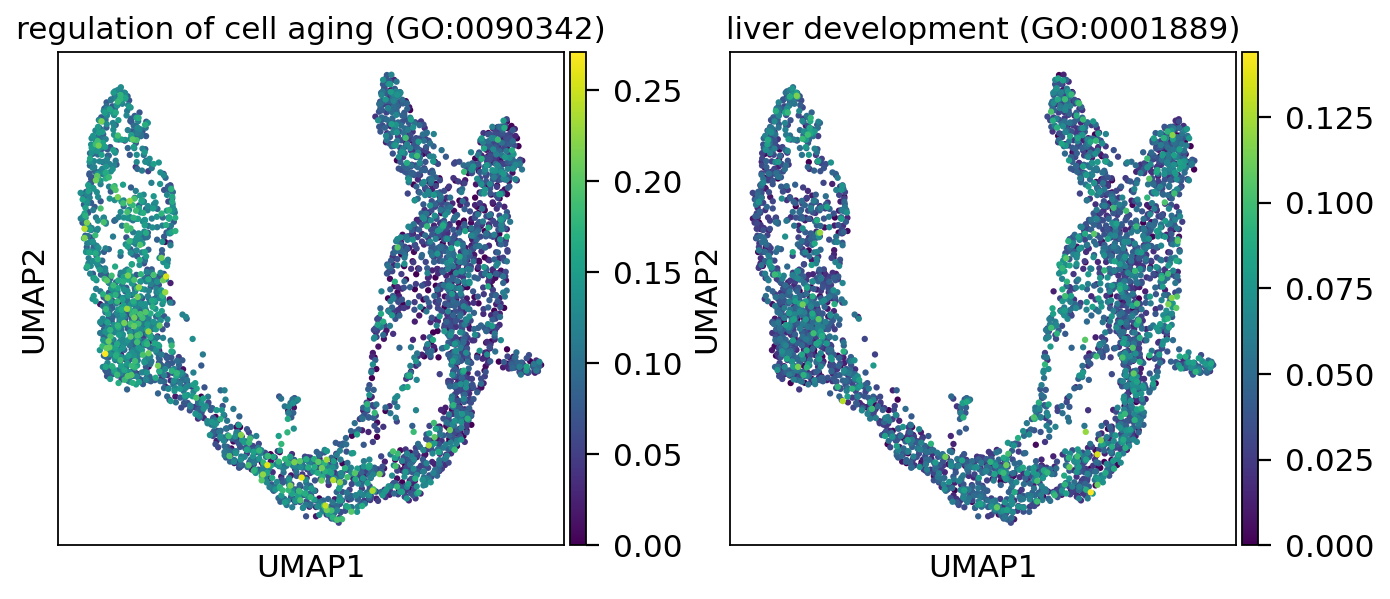

In [16]:
sc.pl.embedding(adata_aucs,
                basis='umap',
          color=["regulation of cell aging (GO:0090342)","liver development (GO:0001889)"])

# Part4. Visualize differential enrichment pathways between different cell clusters.

We first read the AUCell scores files of all previously calculated signal pathways。

In [17]:
adata_aucs=sc.read('/content/pancreas_auce.h5ad')

In [18]:
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'regulation of cell aging (GO:0090342)_aucell', 'liver development (GO:0001889)_aucell', 'Sox_aucell'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

Given that the AUCell score is stored in the anndata structure, and is roughly equivalent to the level of gene expression, we can utilize the algorithm that calculates differential expression genes across clusters from Scanpy  to determine clusters-specific signaling pathways, such as `sc.tl.rank_genes_groups`. By employing this approach, we can identify the pathways that are most distinctive to certain clusters and gain a better understanding of their underlying biology.


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`


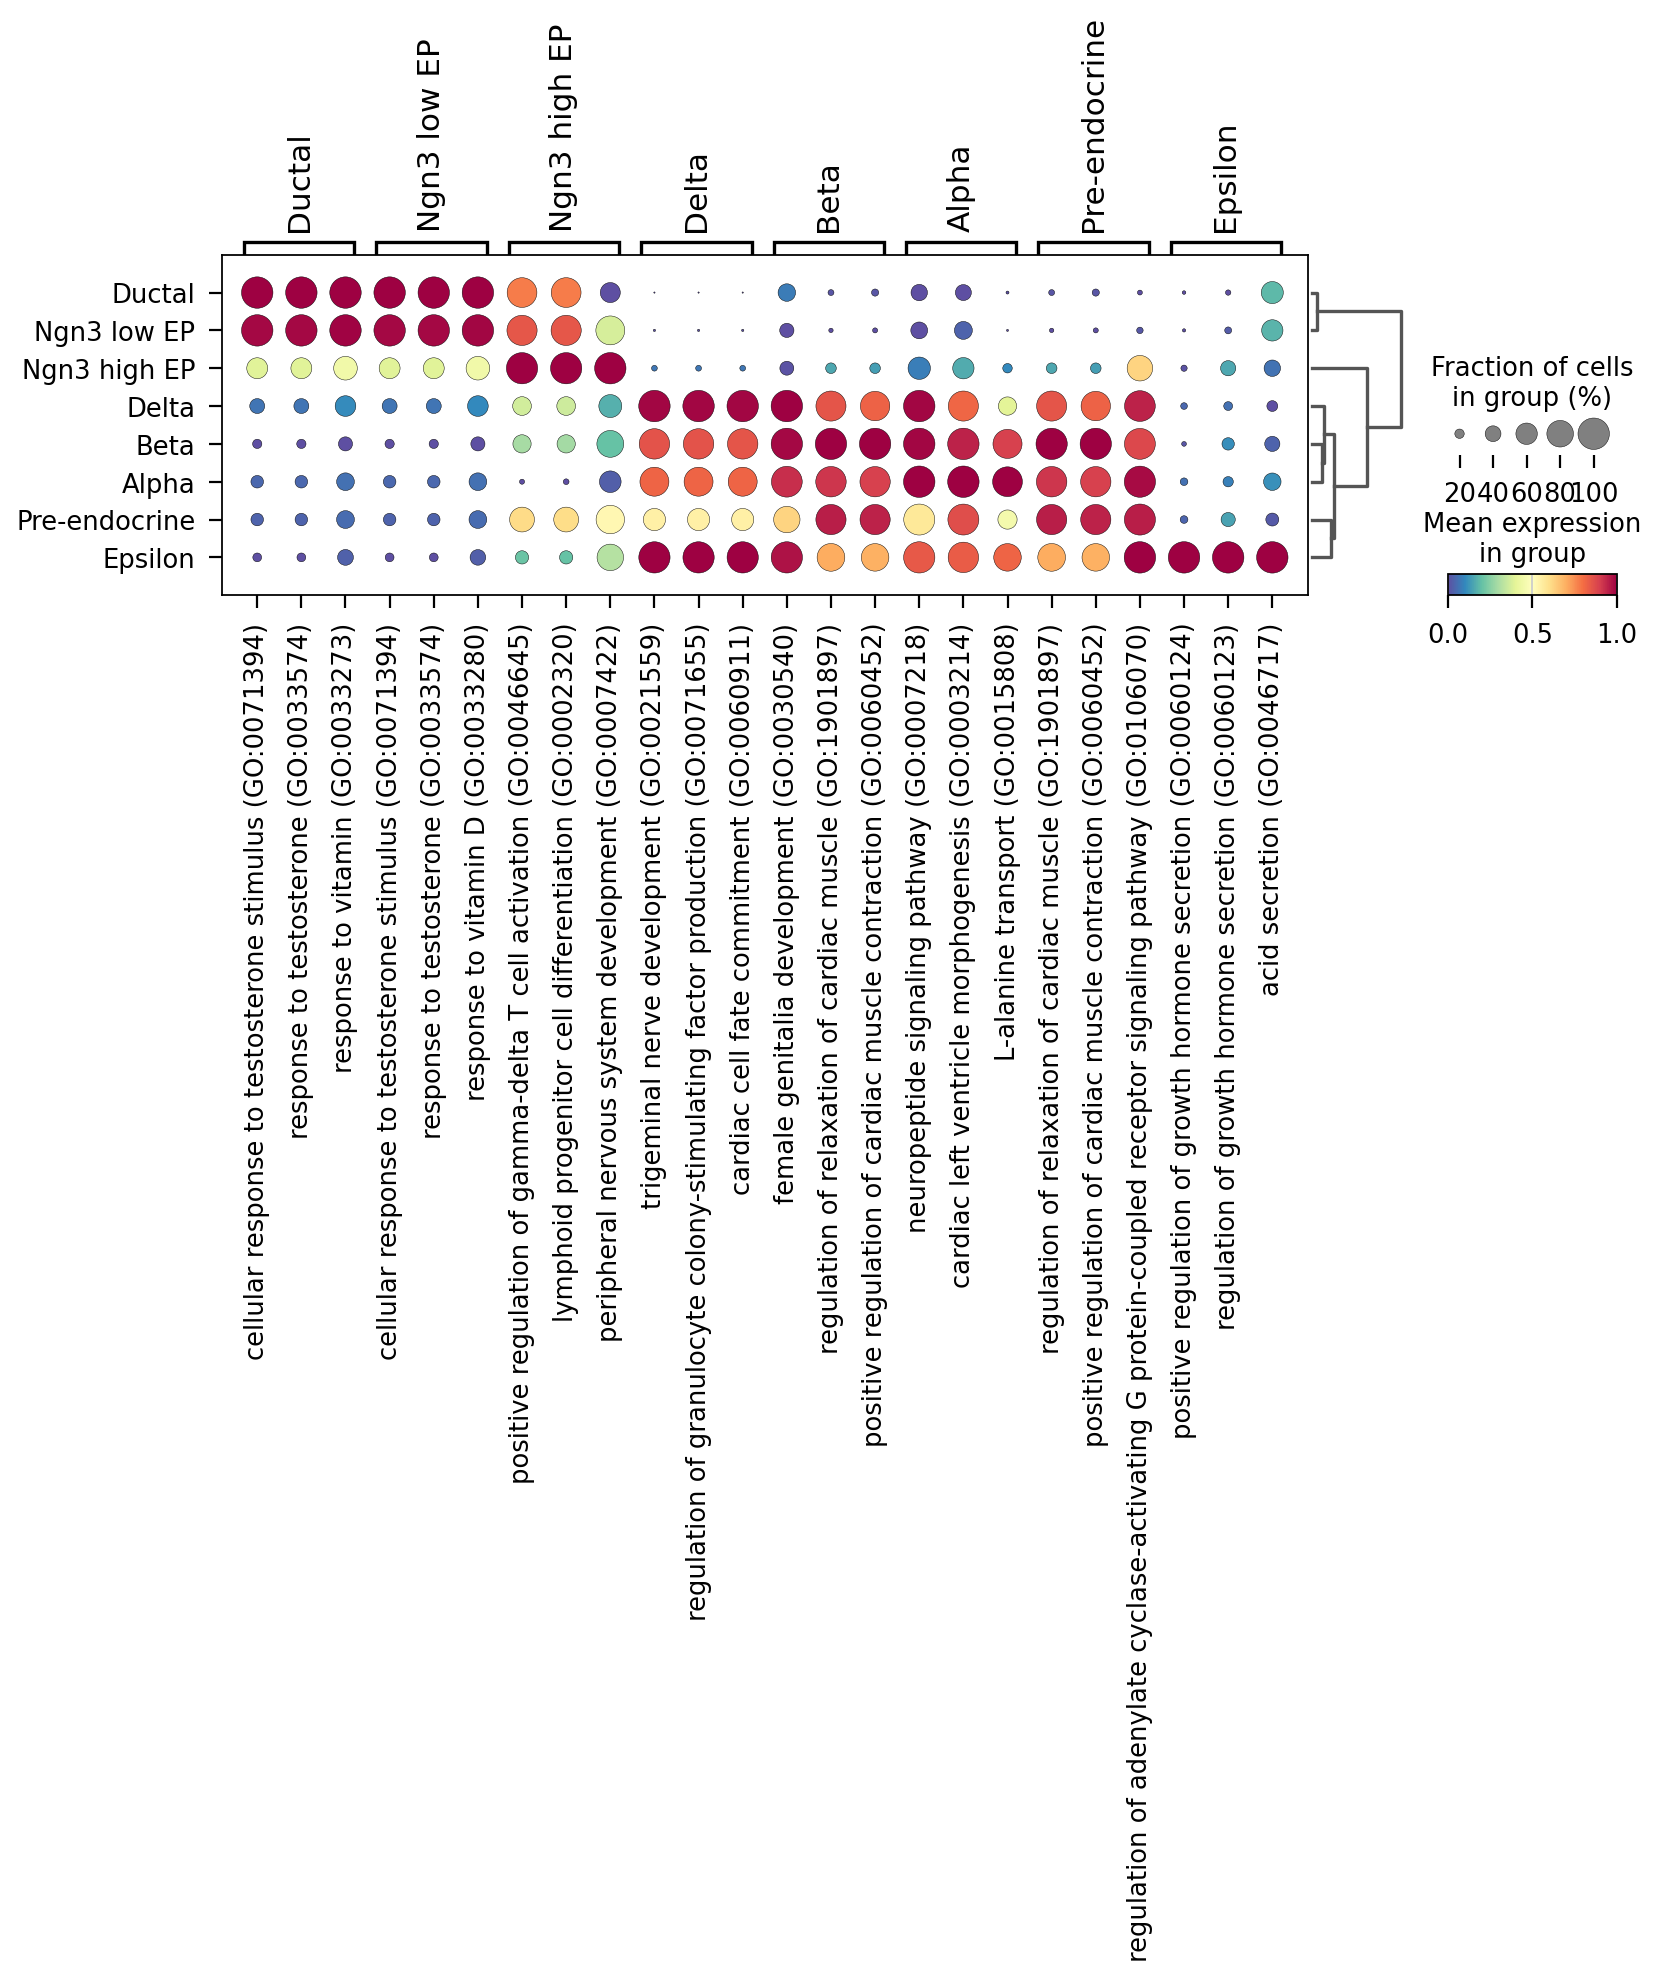

In [19]:
#adata_aucs.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata_aucs, 'clusters', method='t-test',n_genes=100)
sc.pl.rank_genes_groups_dotplot(adata_aucs,groupby='clusters',
                                cmap='Spectral_r',
                                standard_scale='var',n_genes=3)

Furthermore, we can extract specific signaling pathways that are unique to particular clusters and then visualize them. By doing so, we can explore the differences between these clusters and gain insights into the molecular mechanisms that underlie these distinctions. 

In [20]:
degs = sc.get.rank_genes_groups_df(adata_aucs, group='Beta', key='rank_genes_groups', log2fc_min=2, 
                                    pval_cutoff=0.05)['names'].squeeze()
degs

0               insulin metabolic process (GO:1901142)
1       amylin receptor signaling pathway (GO:0097647)
2    calcitonin family receptor signaling pathway (...
Name: names, dtype: object

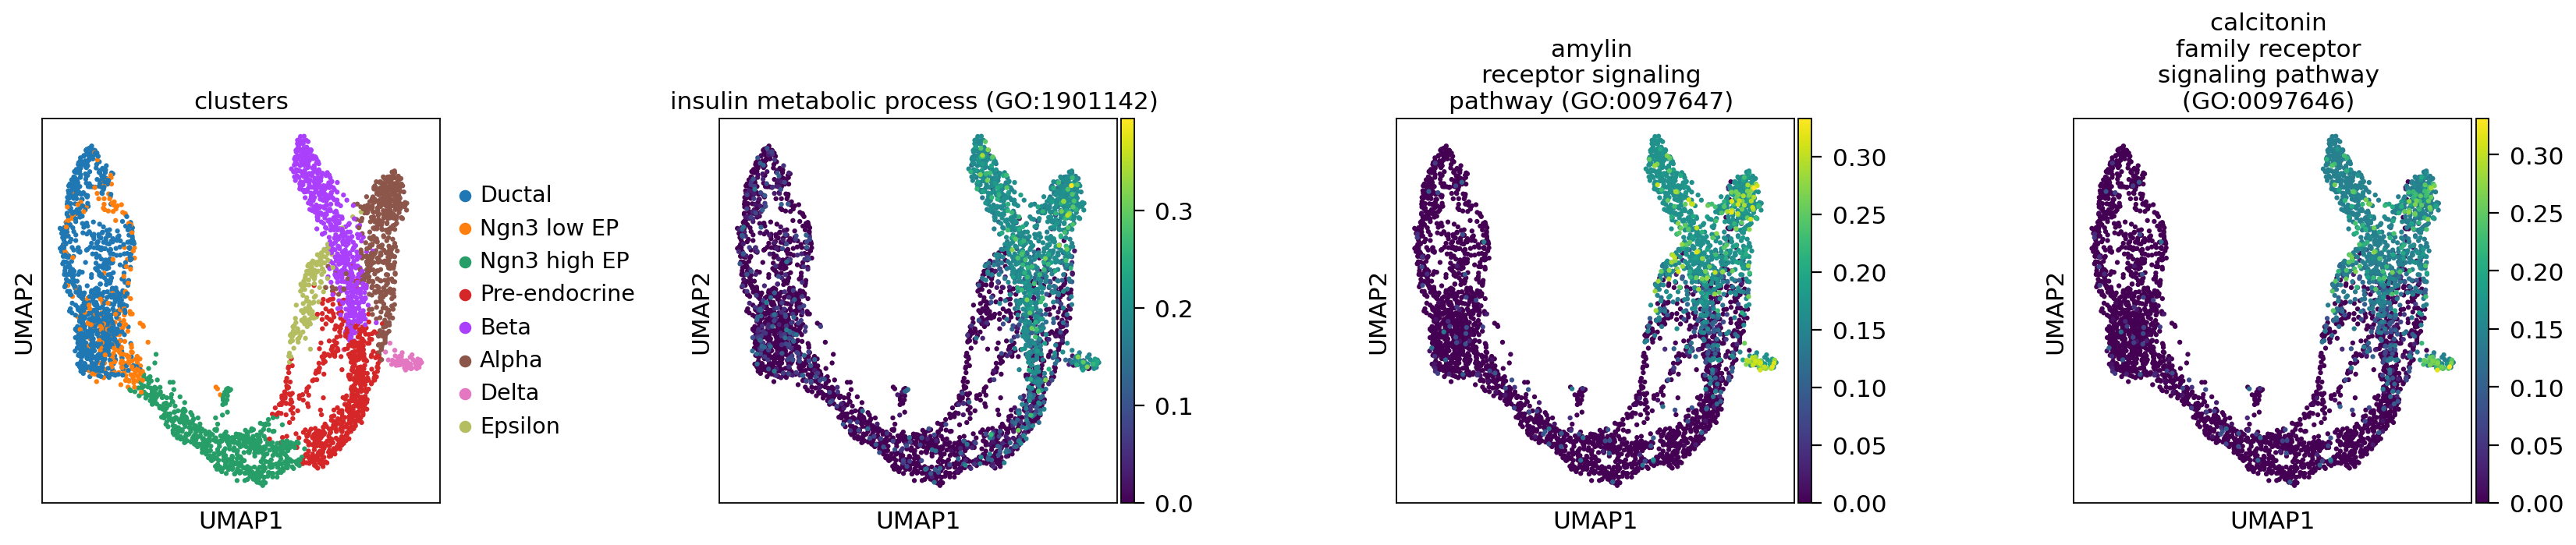

In [21]:
import matplotlib.pyplot as plt
#fig, axes = plt.subplots(4,3,figsize=(12,9))
axes=sc.pl.embedding(adata_aucs,
                basis='umap',show=False,return_fig=True,wspace=0.55,hspace=0.65,
                color=['clusters']+degs.values.tolist(),
                title=[Pyomic.utils.plot_text_set(i,3,20)for i in ['clusters']+degs.values.tolist()])

axes.tight_layout()

In [22]:
adata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata, 'clusters', method='t-test',n_genes=100)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


In [28]:
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'regulation of cell aging (GO:0090342)_aucell', 'liver development (GO:0001889)_aucell', 'Sox_aucell'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

Additionally, we can calculate and visualize specific signaling pathways for all clusters with the function `Pyomic.single.pathway_enrichment`.




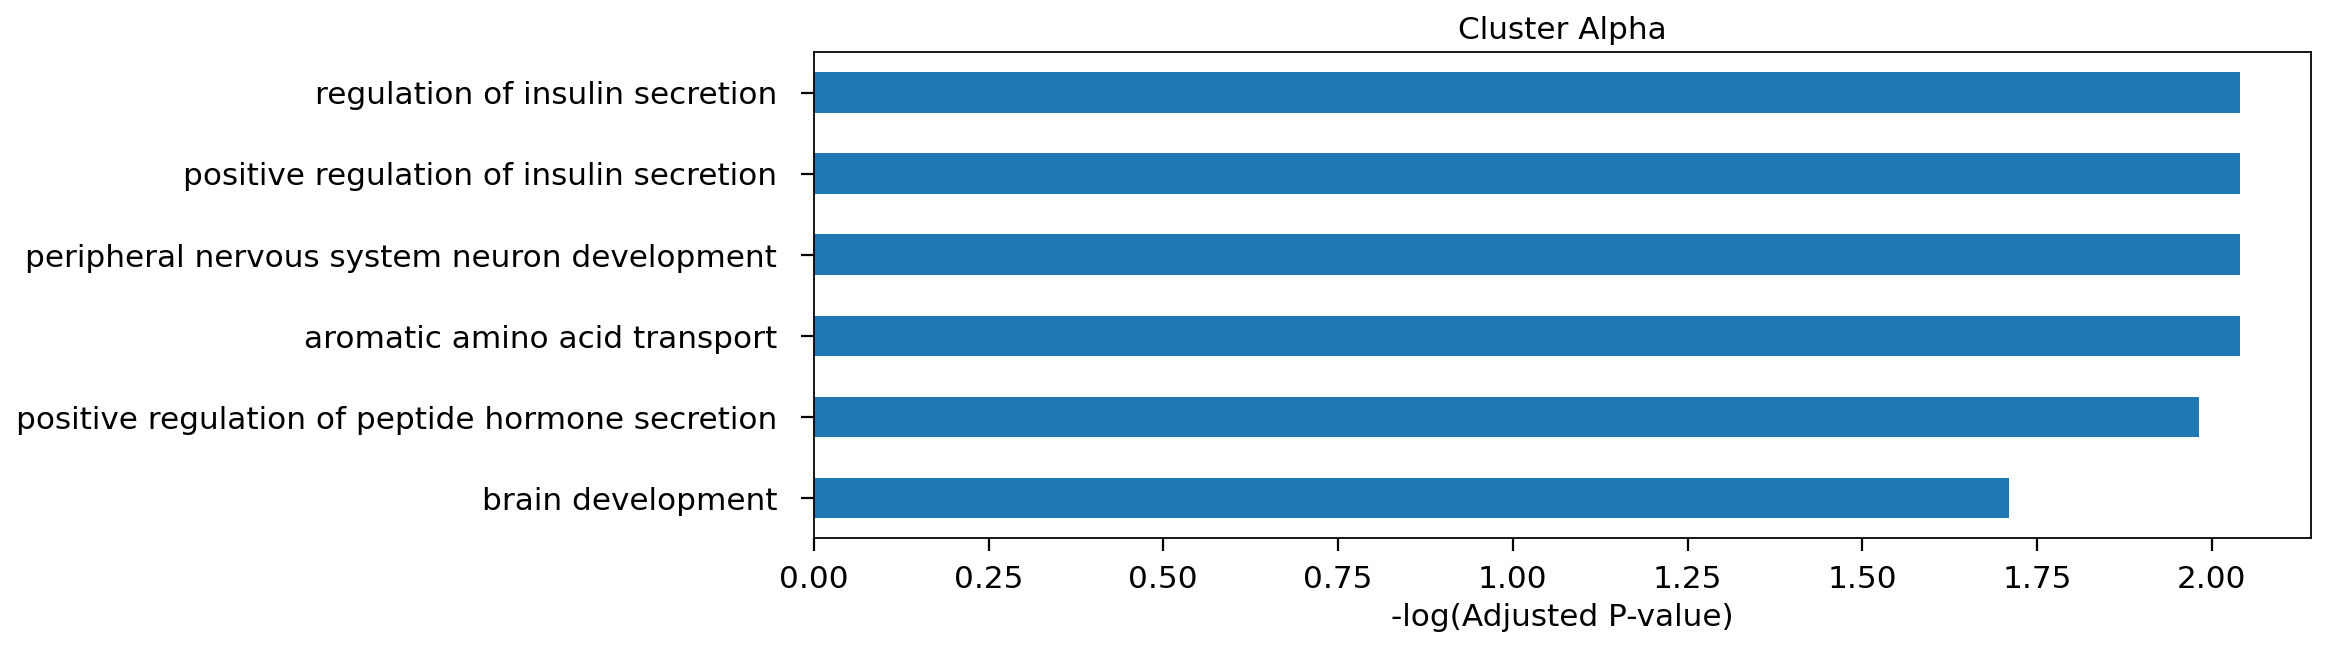

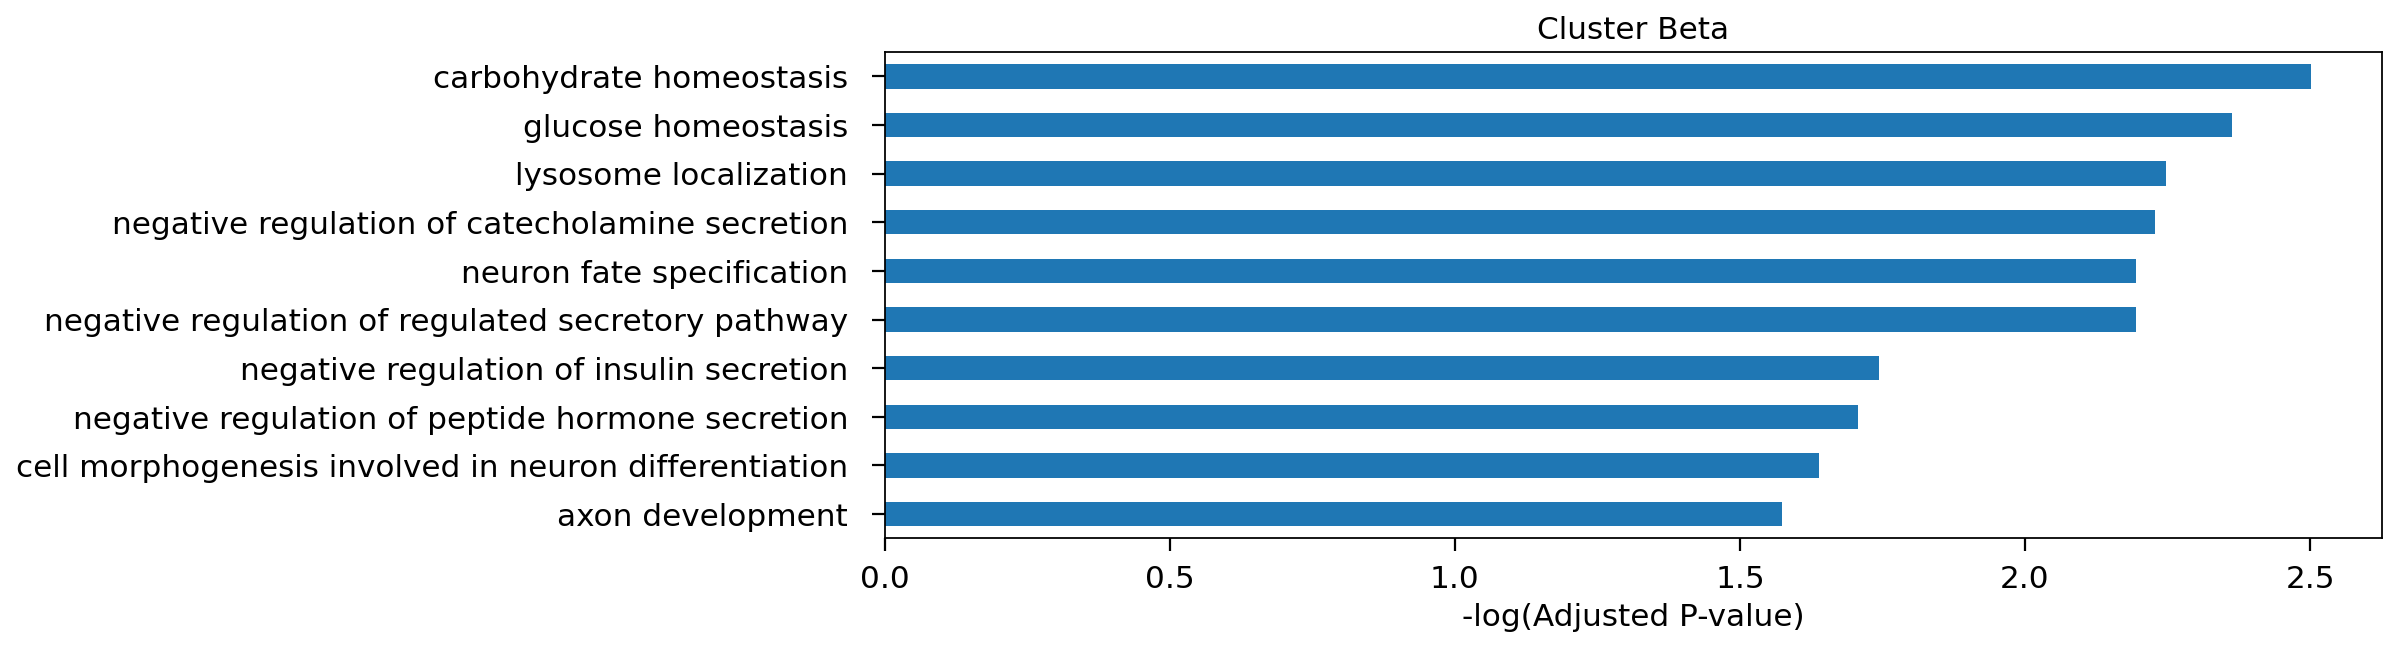

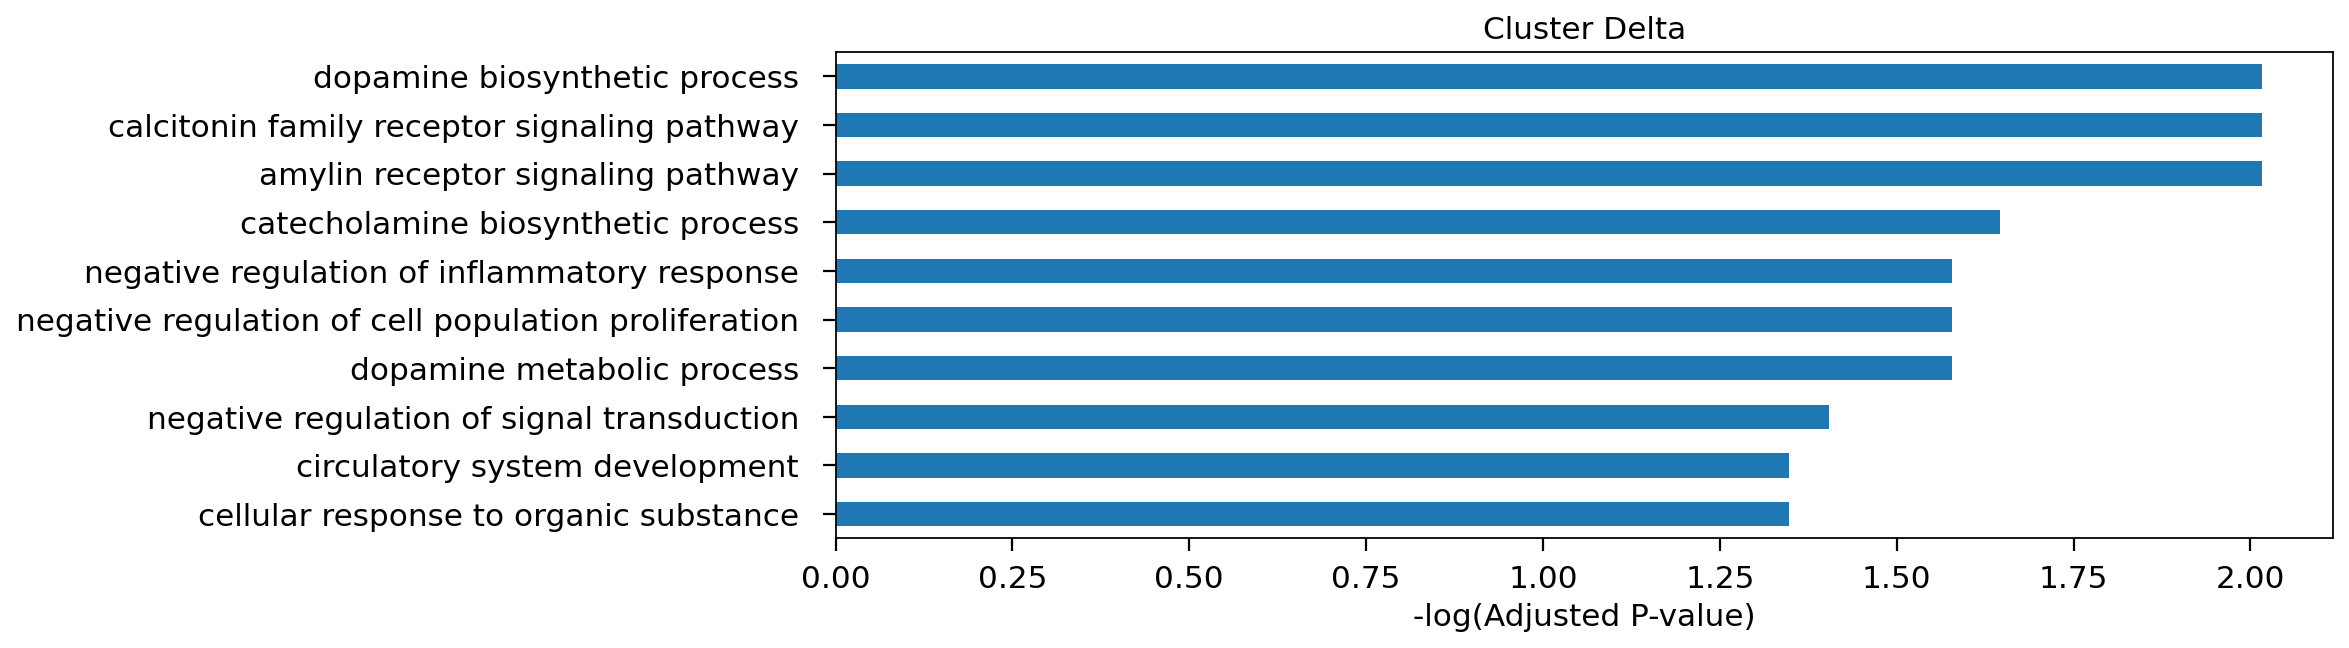

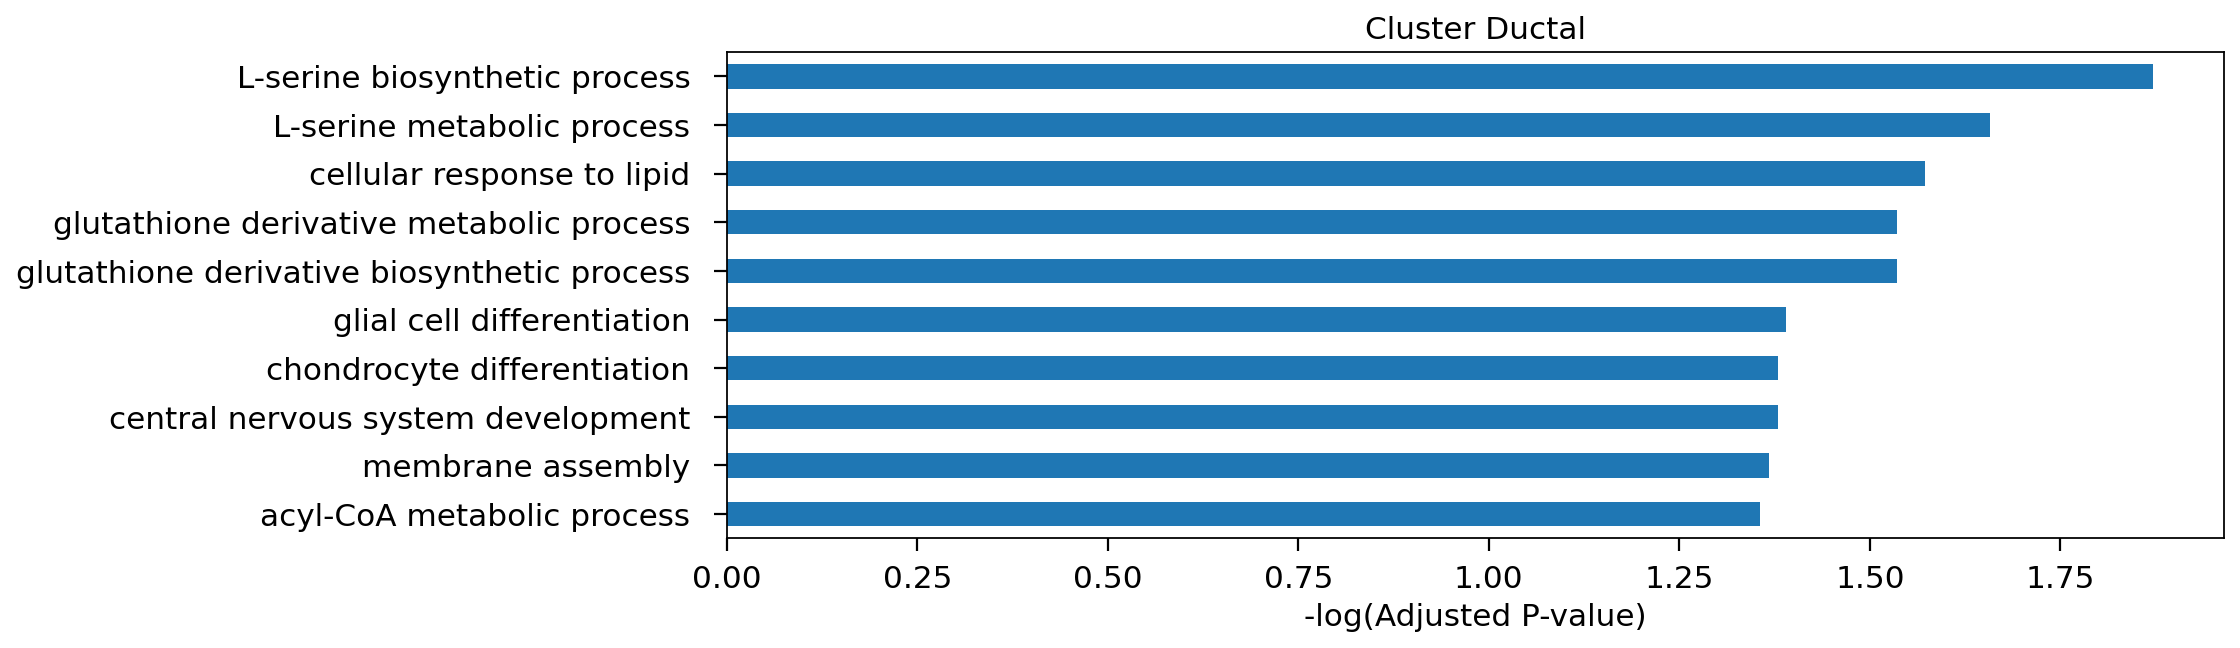

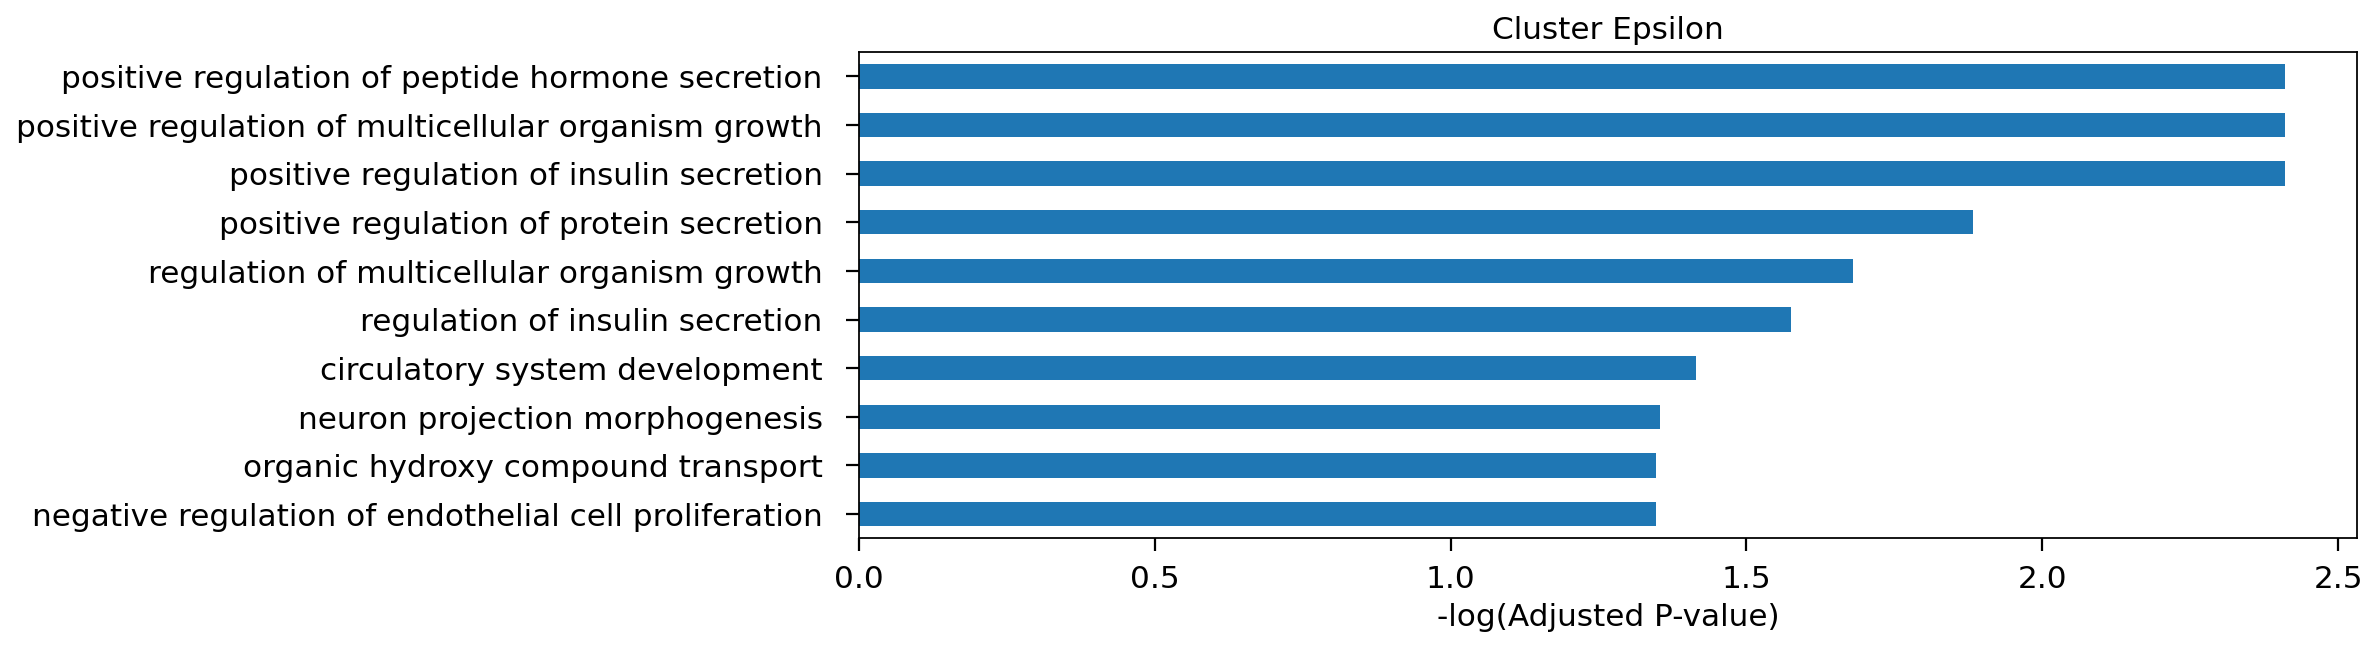

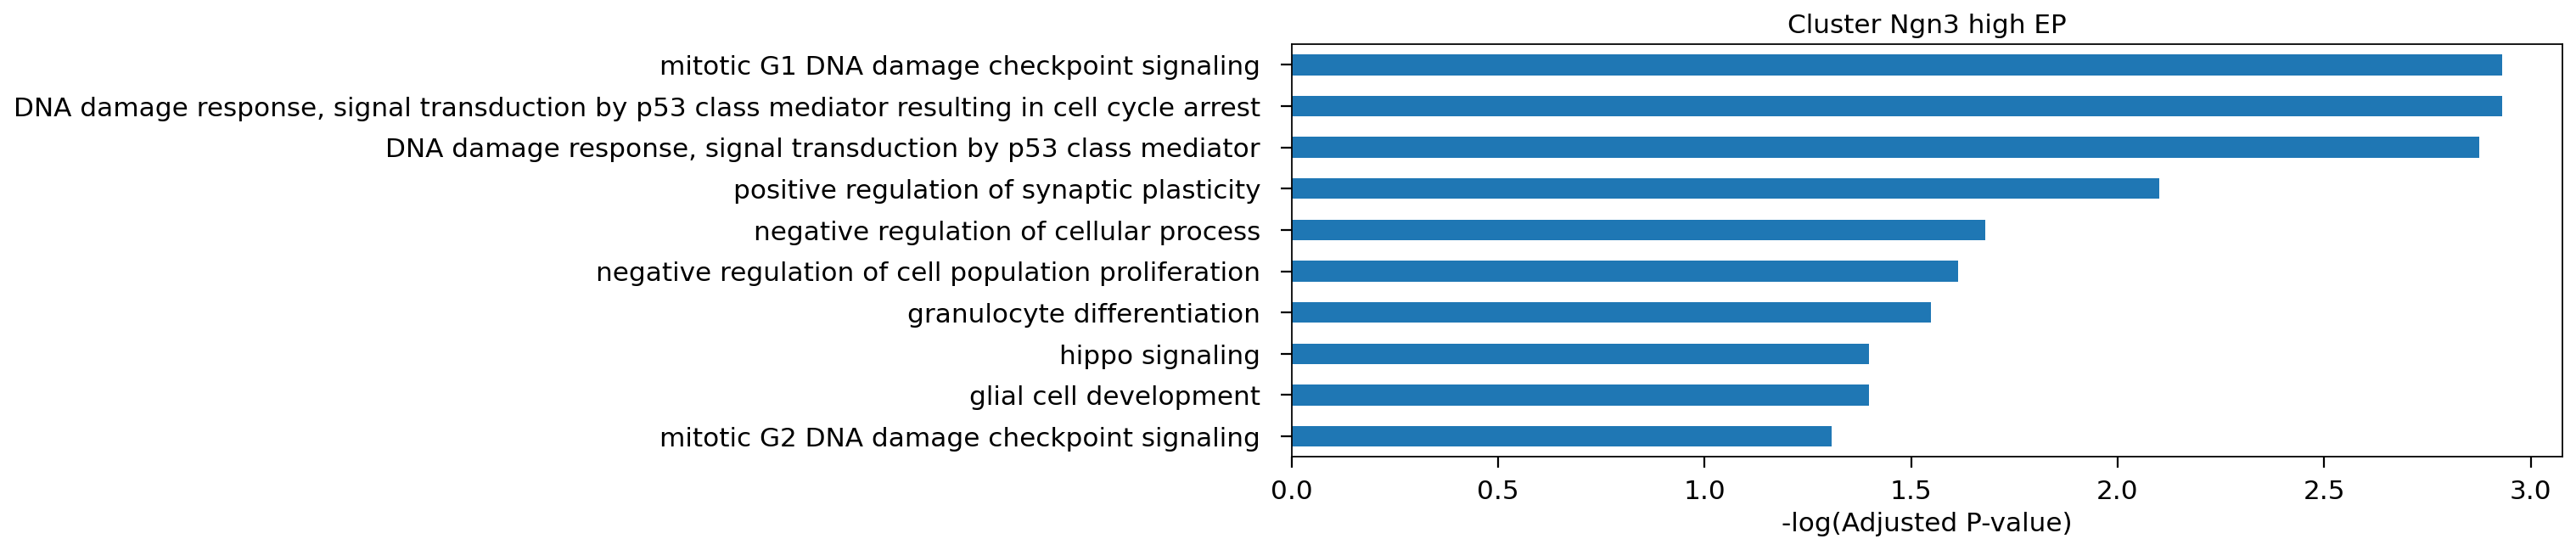

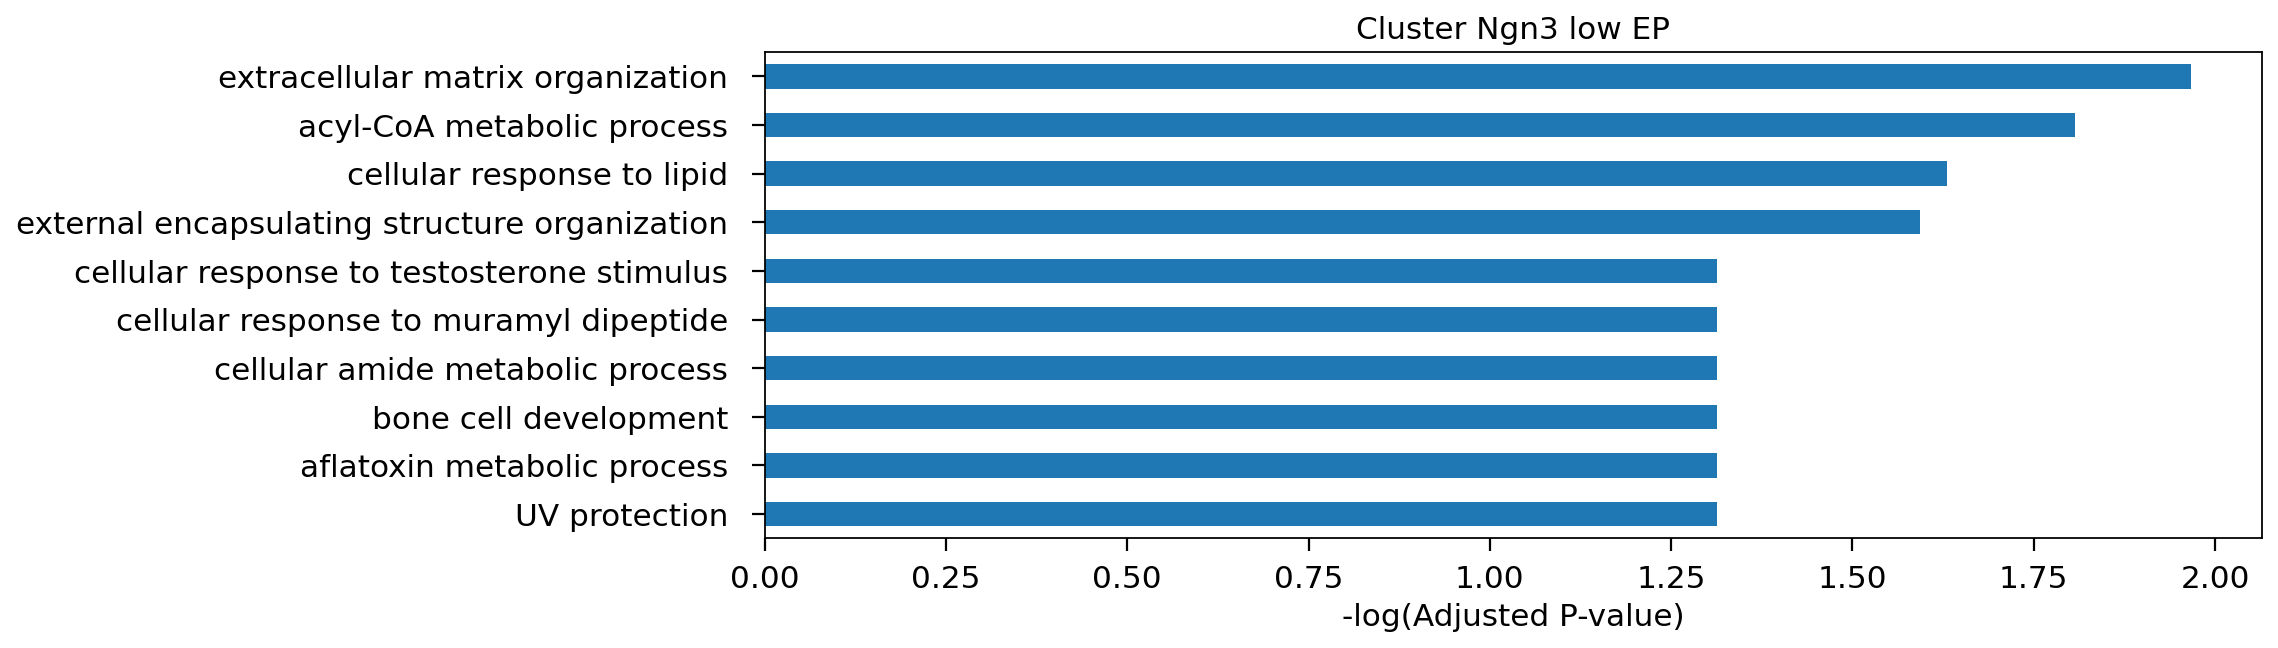

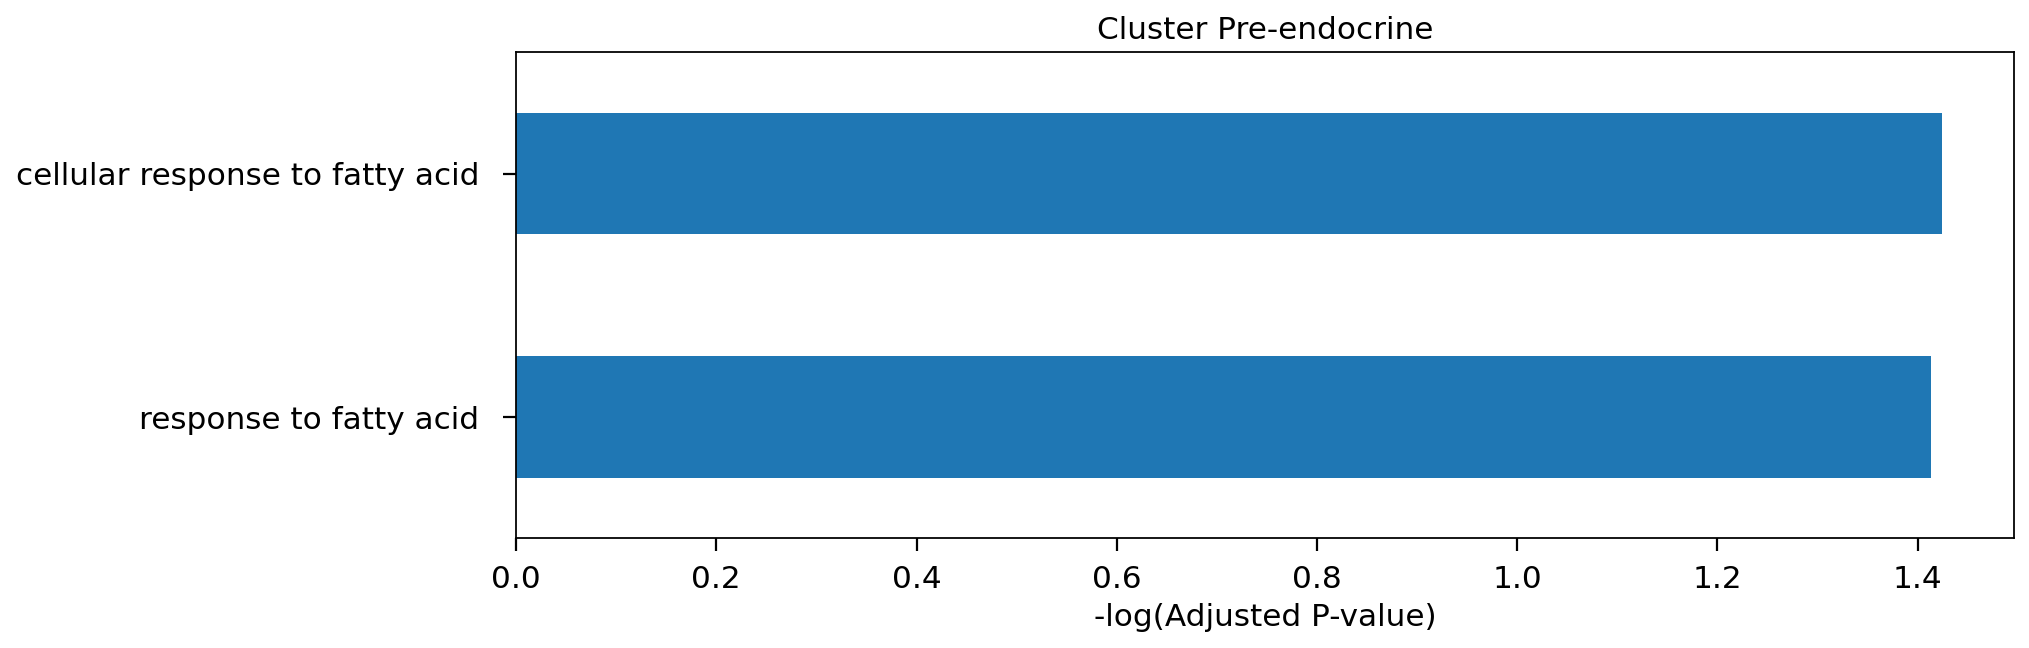

In [43]:
res=Pyomic.single.pathway_enrichment(adata,pathways_dict=pathway_dict,organism='Mouse',
                                     group_by='clusters',plot=True)

To complete our analysis, we can use heatmaps to visualize the specific signaling pathways of each clusters with the function `Pyomic.single.pathway_enrichment_plot`, with the depth of color reflecting the AUCell score for each respective clusters. This approach enables us to easily visualize and compare the activity of various signaling pathways across different clusters. By examining the heatmaps, we can identify patterns and differences between the clusters, providing us with a more in-depth understanding of the underlying biological mechanisms. Overall, this approach can be a powerful tool for identifying novel therapeutic targets and guiding the development of personalized treatments.





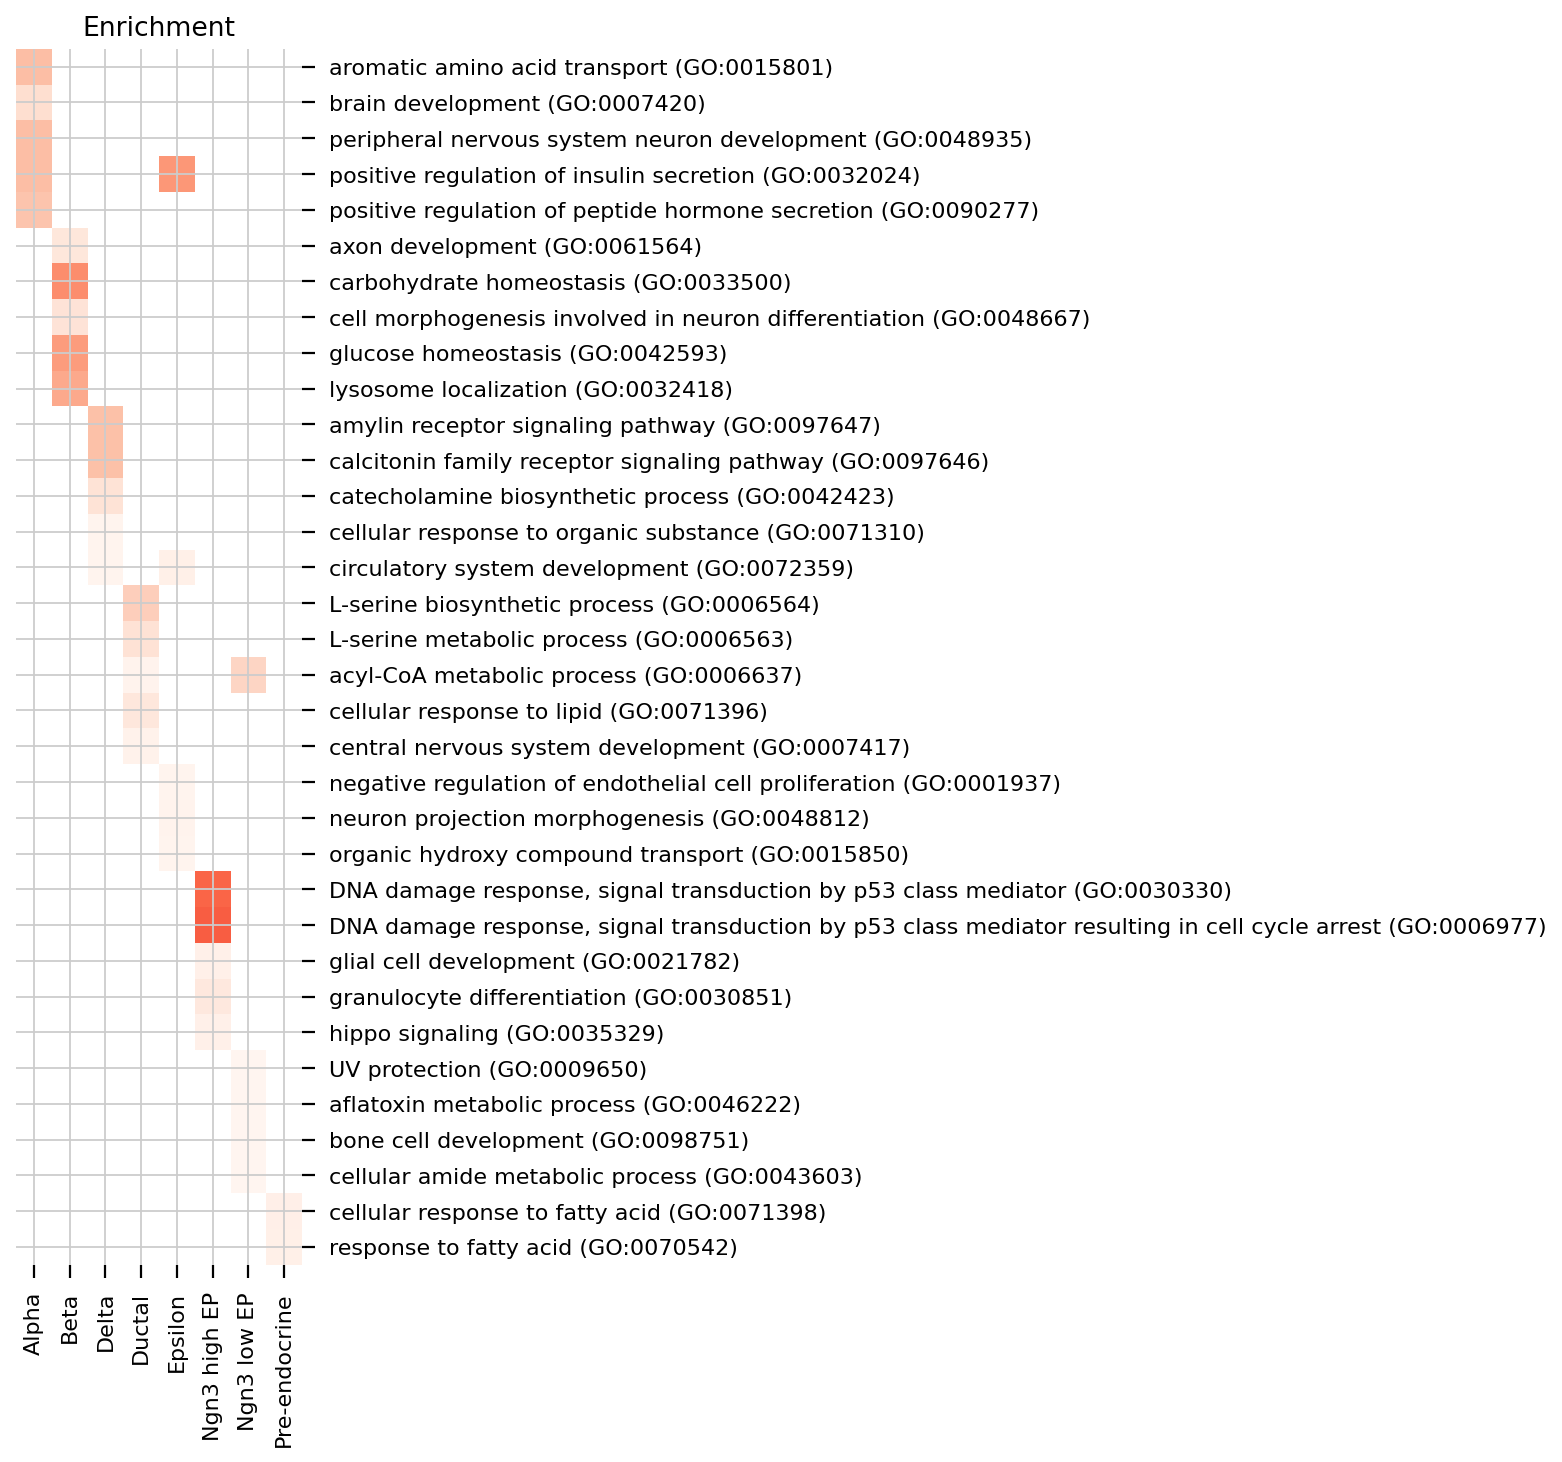

In [44]:
ax=Pyomic.single.pathway_enrichment_plot(res,plot_title='Enrichment',cmap='Reds',
                                         xticklabels=True,cbar=False,square=True,vmax=10,
                                         yticklabels=True,cbar_kws={'label': '-log10(qvalue)','shrink': 0.5,})